# Swath and flight altitude extraction from point cloud

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import os
from scipy.spatial import ConvexHull

In [2]:
from matplotlib import transforms

def get_perp_vec(u1, u2, direction=1):
    """Return the unit vector perpendicular to the vector u2-u1."""

    x1, y1 = u1
    x2, y2 = u2
    vx, vy = x2-x1, y2-y1
    v = np.linalg.norm((vx, vy))
    wx, wy = -vy/v * direction, vx/v * direction
    return wx, wy

def get_av_vec(u1, u2):
    """Return the average unit vector between u1 and u2."""

    u1x, u1y = u1
    u2x, u2y = u2
    dx, dy = u1x + u2x, u1y + u2y
    dlen = np.linalg.norm((dx,dy))
    return dx/dlen, dy/dlen

class LineTicks:
    def __init__(self, line, idx, tick_length, direction=1, label=None,
                 **kwargs):
        self.line = line
        self.idx = idx
        self.tick_length = tick_length
        self.direction = direction
        self.label = label
        self.ticks = []
        self.tick_labels = []

        self.tick_styles = kwargs
        # If no colour is specified for the ticks, set it to the line colour
        if not set(('c', 'color')).intersection(kwargs.keys()):
            self.tick_styles['color'] = self.line.get_color()

        self.ax = line.axes
        self.ax.callbacks.connect('xlim_changed', self.on_change_lims)
        self.ax.callbacks.connect('ylim_changed', self.on_change_lims)
        cid = self.ax.figure.canvas.mpl_connect('resize_event',self.on_resize) 
        self.add_ticks(self.ax)

    def add_ticks(self, ax):
        ax.set_autoscale_on(False)  # Otherwise, infinite loop
        # Transform to  display coordinates
        z =ax.transData.transform(np.array(self.line.get_data()).T)
        x, y = zip(*z)

        # Remove existing ticks
        for tick in self.ticks:
            ax.lines.remove(tick)
        # Remove references to the ticks so they can be garbage-collected
        self.ticks = []

        # Remove any existing tick labels
        for ticklabel in self.tick_labels:
            ax.texts.remove(ticklabel)
        self.tick_labels = []

        for j,i in enumerate(self.idx):
            if i == 0:
                # The first tick is perpendicular to the line between the
                # first two points
                tx, ty = get_perp_vec((x[0], y[0]), (x[1], y[1]),
                                      self.direction)
            elif i == len(x)-1:
                # The last tick is perpendicular to the line between the
                # last two points
                tx, ty = get_perp_vec((x[-2], y[-2]), (x[-1], y[-1]),
                                      self.direction)
            else:
                # General tick marks bisect the incoming and outgoing line
                # segments
                u1 = get_perp_vec((x[i-1], y[i-1]), (x[i], y[i]),
                                  self.direction)
                u2 = get_perp_vec((x[i], y[i]), (x[i+1], y[i+1]),
                                  self.direction)
                tx, ty = get_av_vec(u1, u2)
            tx, ty = self.tick_length * tx, self.tick_length * ty
            this_tick, = ax.plot((x[i],x[i]+tx), (y[i],y[i]+ty),
                transform=transforms.IdentityTransform(), **self.tick_styles)
            self.ticks.append(this_tick)

            if self.label:
                this_ticklabel = ax.text(x[i]+tx*3, y[i]+ty*3, self.label[j],
                        transform=transforms.IdentityTransform(),
                        ha='center', va='center', clip_on=True)
                self.tick_labels.append(this_ticklabel)

    def on_change_lims(self, ax):
        self.add_ticks(ax)

    def on_resize(self, event):
        self.add_ticks(self.ax)

In [3]:
def stat_overview(name, np_array):
    mean = np.mean(np_array)
    median = np.median(np_array)
    stddev = np.std(np_array)
    var = np.var(np_array)
    print('{} mean: {}'.format(name, mean))
    print('{} : median {}'.format(name, median))
    print('{} standard diff: {}'.format(name, stddev))
    print('{} variance: {}'.format(name, var))
    return mean, median, stddev, var


In [4]:
# Functions to calculate distance between to 3D points and flight alt from swath width
def calc_dist(p1, p2):
    xdist = p2[0]-p1[0]
    ydist = p2[1]-p1[1]
    zdist = p2[2]-p1[2]
    
    dist = pow((pow(xdist, 2) + pow(ydist, 2) + pow(zdist, 2)), 0.5)
    print('Distance between {}, {}, {} and {}, {}, {} is {}'.format(p1[0], p1[1], p1[2], p2[0], p2[1], p2[2], dist))
    return dist

def calc_flight_alt(swath_width, scan_angle):
    from math import tan, radians
    altitude = swath_width/(2*tan(radians(scan_angle)))
    return altitude

def calc_centre_2d(p1, p2):
    x = p1[0]+(p2[0]-p1[0])/2
    y = p1[1]+(p2[1]-p1[1])/2

    return [x, y]

In [5]:
def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [6]:
filename = r'D:\ws_21_22\bachelor_arbeit\data\norway_small\data\merged.las'
filename2 = r'D:\ws_21_22\bachelor_arbeit\data\antarctica\points.las'
filename = r"E:\ws_21_22\bachelor_arbeit\data\generated_data\test_data2\merged_data_27.las"
#filename = r"E:\ws_21_22\bachelor_arbeit\data\NationalDatasets\norway_small\data\merged.laz"
#filename = r'D:\ws_21_22\bachelor_arbeit\data\antarctica\points.laz'

## Step 1: Retrieve individual swath.
***
1.1: Print some **metadata**.

In [7]:
with laspy.open(filename) as f:
    point_format = f.header.point_format
    scale = f.header.scale
    offset = f.header.offset
    point_num = f.header.point_count
    print(f"Point format:       {point_format}")
    print(f"Number of points:   {point_num}")
    print(f"Number of vlrs:     {len(f.header.vlrs)}")
    print(list(point_format.standard_dimension_names))
    print(f.header.scale)
    print(f.header.offset)

Point format:       <PointFormat(1, 24 bytes of extra dims)>
Number of points:   8377836
Number of vlrs:     1
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']
[0.0001 0.0001 0.0001]
[4.65335126e+05 5.46498789e+06 3.40000000e+01]


***
1.2: Load file into python and **store desired columns in numpy array**, close file.

In [8]:
# Read file to numpy array
las = laspy.read(filename)[::700]
filtered_pc = np.array([las.X, las.Y, las.Z, las.gps_time])
# Scale values in accordance with factors from header
for i in range(3):
    filtered_pc[i,:] = filtered_pc[i,:]*scale[i]+offset[i]
las = None

print(np.shape(filtered_pc)[1])

11969


***
1.3: Calculate some basic **statistics**.

In [9]:
# Get statistics of gps time
mean, median, stddev, var = stat_overview('GPS time', filtered_pc[3, :])


GPS time mean: 324807.1717466789
GPS time : median 324807.253
GPS time standard diff: 71.43749968596973
GPS time variance: 5103.316361382924


***
1.4: **Sort points by GPS time** and cut away upper and lower 10% of points.

In [10]:
# Sort points by gps time - lowest to highest
filtered_pc = filtered_pc[:, filtered_pc[3, :].argsort()]

In [11]:
# Cut away some points to get rid of outlying swaths
#print('Number of points before cut: {}'.format(np.shape(filtered_pc)[1]))
#filtered_pc = filtered_pc[:, int(np.shape(filtered_pc)[1]/10):int(np.shape(filtered_pc)[1]-np.shape(filtered_pc)[1]/10)]
#print('Number of points after cut: {}'.format(np.shape(filtered_pc)[1]))

In [12]:
# Get average distances between points
gps_diffs = [abs(filtered_pc[3, i]-filtered_pc[3, i+1]) for i in range(np.shape(filtered_pc)[1]-1)]
gpsdif_stats = stat_overview('GPS-time difference', gps_diffs)

GPS-time difference mean: 0.019869903074867516
GPS-time difference : median 0.01699999999254942
GPS-time difference standard diff: 0.18109706678126594
GPS-time difference variance: 0.0327961475967783


**Result of first file processing:** A heavily **subsampled** and **clipped** point cloud array sorted by gps time. Columns are `[X, Y, Z, gps_time]`.

## Step 2: Point cloud analysis: determine individual flight swaths
***
2.1: Add fourth column to array with **numbers assigned for each likely flight swath**. `sensitivity` defines minimum gap in seconds between two points for a new swath to be assigned to the following points.

In [13]:
np.shape(filtered_pc)[1]

11969

In [14]:
sensitivity = 7
#sensitivity = 200

# Add empty col for trajectory vals to pc array
trajectory_col = np.empty((1, np.shape(filtered_pc)[1]), dtype=float)
filtered_pc = np.vstack([filtered_pc, trajectory_col])


# Iterate through gps time vals to determine gaps large enough to indicate new swath
trajectory = 0
swath_extents = [0]
for i in range(np.shape(filtered_pc)[1]-1):
    filtered_pc[4, i] = trajectory
    if (abs(filtered_pc[3, i]-filtered_pc[3, i+1])>sensitivity):
        print('Distance between gps times over {}s.'.format(sensitivity))
        swath_extents.append(i+1)
        trajectory += 1
swath_extents.append(np.shape(filtered_pc)[1]-1)

# Get sizes of swaths
swath_sizes = [swath_extents[i+1]-swath_extents[i] for i in range(len(swath_extents)-1)]

# Output info on swaths
print('Number of swaths found: {}'.format(len(swath_extents)-1))
formatted_swaths = [[i+1, swath_sizes[i]] for i in range(len(swath_sizes))]
formatted_swaths.insert(0, ["swath nr.", "number of points"])
print(tabulate(list(zip(*formatted_swaths))))

Distance between gps times over 7s.
Distance between gps times over 7s.
Number of swaths found: 3
----------------  ----  ----  ----
swath nr.            1     2     3
number of points  3917  4007  4044
----------------  ----  ----  ----


***
2.2: Print **size and shape of array** with trajectory column.

In [15]:
print('Point cloud array from file {}'.format(filename))
print('Shape: ')
print(np.shape(filtered_pc))
print('\nSize: ')
print('{} bytes = {} gbytes'.format(filtered_pc.itemsize * filtered_pc.size, filtered_pc.itemsize * filtered_pc.size/1000000000))

Point cloud array from file E:\ws_21_22\bachelor_arbeit\data\generated_data\test_data2\merged_data_27.las
Shape: 
(5, 11969)

Size: 
478760 bytes = 0.00047876 gbytes


***
2.3: Plot **histogram of point cloud along GPS time** with colours indicating assigned trajectory (visual check for swath separation).

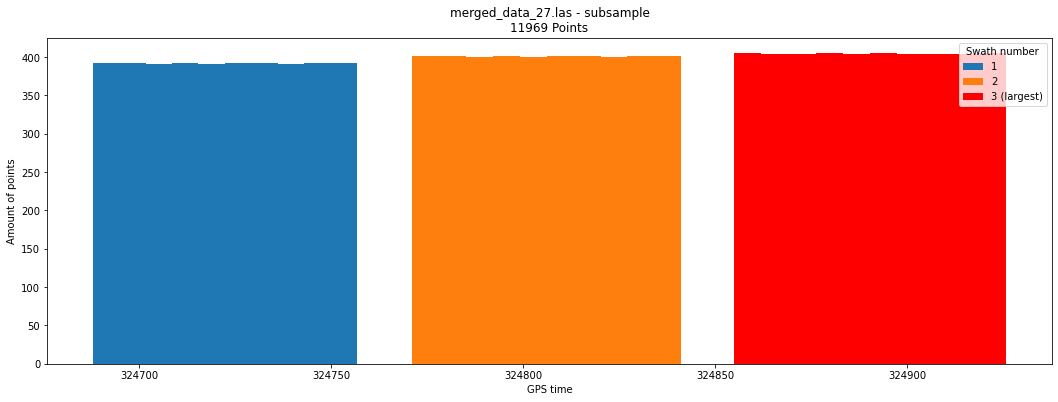

In [16]:
plt.figure(figsize=(18,6))
# Plot histogram of gps times, coloured by individual swaths
for i in range(len(swath_extents)-1):
    if i ==swath_sizes.index(max(swath_sizes)):
        plt.hist(filtered_pc[3,swath_extents[i]:swath_extents[i+1]], bins=10, label='{} (largest)'.format(i+1), color='red')
    else:
        plt.hist(filtered_pc[3,swath_extents[i]:swath_extents[i+1]], bins=10, label=i+1)#, color='blue')
    
plt.title('{} - subsample\n{} Points'.format(os.path.basename(filename), np.shape(filtered_pc)[1]))
plt.legend(title='Swath number')
plt.ylabel('Amount of points')
plt.xlabel('GPS time')
plt.show()

***
2.4: Filter out **swath with highest number of points** (`swath`) and plot 2d shape of swath for visual check. Swath number set through variable `swath_nr`.

In [17]:
swath_nr = swath_sizes.index(max(swath_sizes))+1
res = 1

# Filter out swath
swath = filtered_pc[:4,swath_extents[swath_nr-1]+1:swath_extents[swath_nr]].swapaxes(0,1)
swath2 = np.copy(swath)

In [18]:
swath[0,0] = 478995.04
swath[0,1] = 5473136
swath[0,2] = 300

swath[1,0] = 478571.04
swath[1,1] = 5472444
swath[1,2] = 300

swath[2,0] = 478613.04
swath[2,1] = 5473011
swath[2,2] = 300

swath[50,0] = 477500.04
swath[50,1] = 5473500
swath[50,2] = 300

swath[52,0] = 478500.04
swath[52,1] = 5474500
swath[52,2] = 300

swath[25,0] = 479500.04
swath[25,1] = 5474100
swath[25,2] = 300

swath[55,0] = 477350.04
swath[55,1] = 5473050
swath[55,2] = 300

***
2.5: Convert swath numpy array to **structured array** for use in PDAL.

In [19]:
import pdal
import numpy.lib.recfunctions as rfn

In [20]:
# Convert array into structured array that is usable for pdal.
list_swath = [swath[:, 0].astype([('X','<f8')]), swath[:, 1].astype([('Y','<f8')]), swath[:, 2].astype([('Z','<f8')])]

structured_swath = rfn.merge_arrays(list_swath, flatten = True, usemask = False)
list_swath = None

## Step 3: Swath analysis - get likely scan parameters
***Altitude/Scan Angle, Flight Velocity***
***
3.1: Calculate **alphashape**. How to find parameter?

0.025


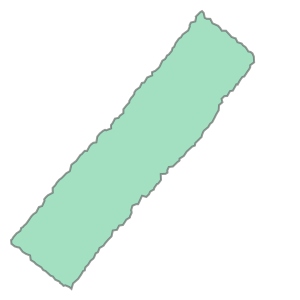

In [21]:
import alphashape
import shapely

# Radius of circle with which alphashape is calculated
alpharadius = 40
alpha_val = 1/alpharadius
print(alpha_val)

# Calculate alphashape
alpha = alphashape.alphashape(swath[:,0:2], alpha=alpha_val)
alpha

In [22]:
# Calculate minimum bounding rectangle on alphashape
alpha_vertices = np.asarray([[float(val) for val in xy.split(' ')] for xy in alpha.wkt.split('((')[1].split('))')[0].split(', ')])
rect = minimum_bounding_rectangle(alpha_vertices)

C:\Users\Mark\AppData\Local\Temp\ipykernel_13220\3569654028.py:9: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


3.4: **Visualize** alphashape.

In [23]:
as_colour = 'r'
bbox_colour = 'dodgerblue'

<IPython.core.display.Javascript object>


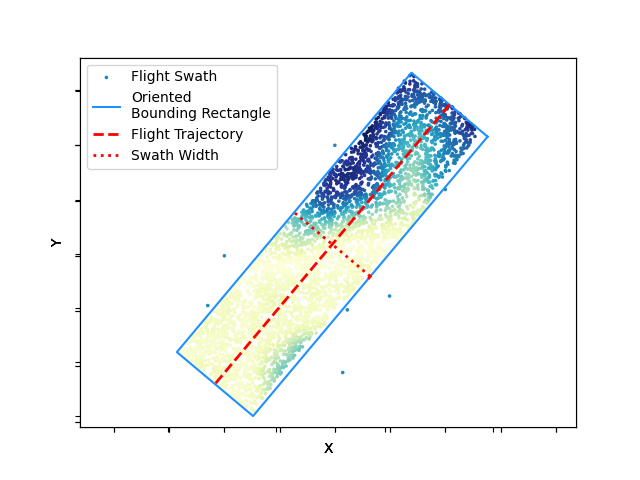

In [24]:
%matplotlib notebook
# Empty arrays for bbox line. Will be updated after calculation of bbox.
x = np.array([])
y = np.array([])

# Scatterplot of swath
fig = plt.figure(num=1)
ax = fig.add_subplot()

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.scatter(swath[::res,0], swath[::res,1], c = swath[::res,2], cmap='YlGnBu', label='Flight Swath', s=2.5)
#plt.title('Swath nr. {}\n{} Points'.format(swath_nr, np.shape(swath)[0]))
#plt.title('Alphashape of Single Flight Swath')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
#plt.colorbar(label='Elevation')
alpha_vertices = [xy.split(' ') for xy in alpha.wkt.split('((')[1].split('))')[0].split(', ')]
line1, = ax.plot([float(xy[0]) for xy in alpha_vertices], [float(xy[1]) for xy in alpha_vertices], 
                 c=as_colour, label='Alphashape')

plt.legend(loc='best')
plt.show()

3.4: **Visualize** oriented bounding box.

<IPython.core.display.Javascript object>


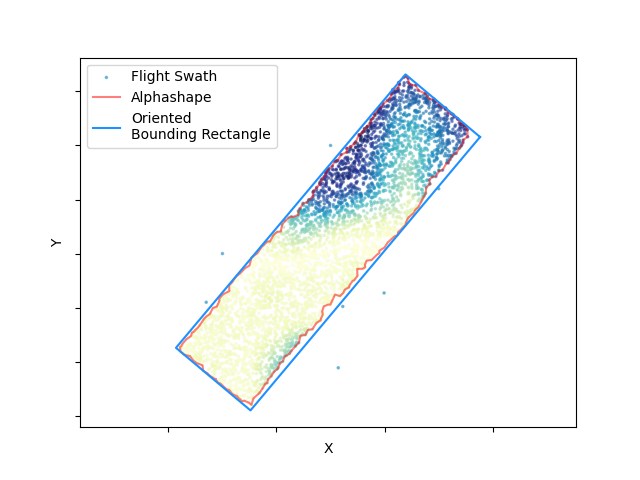

In [59]:
%matplotlib notebook
# Empty arrays for bbox line. Will be updated after calculation of bbox.
x = np.array([])
y = np.array([])

# Scatterplot of swath
fig = plt.figure(num=1)
ax = fig.add_subplot()

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.scatter(swath[::res,0], swath[::res,1], c = swath[::res,2], cmap='YlGnBu', label='Flight Swath', s=2.5, alpha=0.5)
#plt.title('Swath nr. {}\n{} Points'.format(swath_nr, np.shape(swath)[0]))
#plt.title('Alphashape of Single Flight Swath')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
#plt.colorbar(label='Elevation')
alpha_vertices = [xy.split(' ') for xy in alpha.wkt.split('((')[1].split('))')[0].split(', ')]
line1, = ax.plot([float(xy[0]) for xy in alpha_vertices], [float(xy[1]) for xy in alpha_vertices], 
                 c=as_colour, label='Alphashape', alpha=0.5)

line2 = ax.plot([pt[0] for pt in rect]+[rect[0][0]], [pt[1] for pt in rect]+[rect[0][1]], c=bbox_colour,
                label='Oriented\nBounding Rectangle')

'''for number, rect_pt in enumerate(rect):
    print(rect[0], rect[1])
    ax.scatter(rect_pt[0], rect_pt[1], label='rect_pt_{}'.format(number))'''

plt.legend(loc='best')
plt.show()

3.5: **Calculate swath width** as width of oriented bounding box. **Calculate flight altitude** using given **swath width** and maximum **scan angle**.

<IPython.core.display.Javascript object>


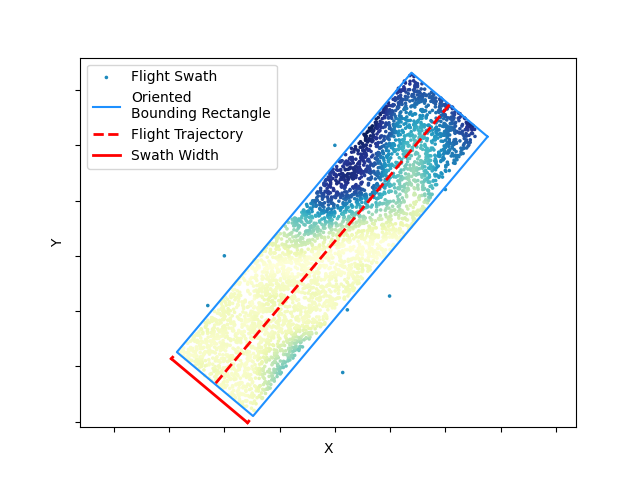

<class 'matplotlib.lines.Line2D'>


In [58]:
%matplotlib notebook

# Empty arrays for bbox line. Will be updated after calculation of bbox.
x = np.array([])
y = np.array([])

# Scatterplot of swath
fig = plt.figure(num=1)
ax = fig.add_subplot()

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.scatter(swath[::res,0], swath[::res,1], c = swath[::res,2], cmap='YlGnBu', label='Flight Swath', s=2.5)
#plt.title('Swath nr. {}\n{} Points'.format(swath_nr, np.shape(swath)[0]))
#plt.title('Alphashape of Single Flight Swath')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
#plt.colorbar(label='Elevation')
alpha_vertices = [xy.split(' ') for xy in alpha.wkt.split('((')[1].split('))')[0].split(', ')]
'''line1, = ax.plot([float(xy[0]) for xy in alpha_vertices], [float(xy[1]) for xy in alpha_vertices], 
                 c=as_colour, label='Alphashape')'''

line2 = ax.plot([pt[0] for pt in rect]+[rect[0][0]], [pt[1] for pt in rect]+[rect[0][1]], c=bbox_colour,
                label='Oriented\nBounding Rectangle')

tp1 = calc_centre_2d(rect[0], rect[3])
tp2 = calc_centre_2d(rect[1], rect[2])

cp1 = calc_centre_2d(rect[0], rect[1])
cp2 = calc_centre_2d(rect[3], rect[2])
    
line3 = ax.plot([tp1[0], tp2[0]], [tp1[1], tp2[1]], '--', c='red', linewidth=2, label='Flight Trajectory')

xdiff = 50
ydiff=60

line4, = ax.plot([rect[1][0]-xdiff, rect[2][0]-xdiff], [rect[1][1]-ydiff, rect[2][1]-ydiff], c='red', linewidth=2, label='Swath Width')

print(type(line4))

major_ticks = LineTicks(line4, [0,1],2, lw=2, c='red', direction=-1)

#arr = ax.arrow(tp1[0]-100, tp1[1]-100, 1, 1.3, fc='red', ec='red', width=30)

'''for number, rect_pt in enumerate(rect):
    print(rect[0], rect[1])
    ax.scatter(rect_pt[0], rect_pt[1], label='rect_pt_{}'.format(number))'''

plt.legend(loc='best')
plt.show()